In [1]:
import time

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler, BackendSampler
import qiskit.providers.fake_provider as fb
from qiskit_algorithms.utils import algorithm_globals

from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_aer.noise import NoiseModel

##### Classical Dataset

In [2]:
iris_data = load_iris()

features = iris_data.data
labels = iris_data.target

# rescale the features
features = MinMaxScaler().fit_transform(features)

In [3]:
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

##### Load Classical Dataset to ZZFeatureMap

/Users/soap/miniconda3/envs/qc/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


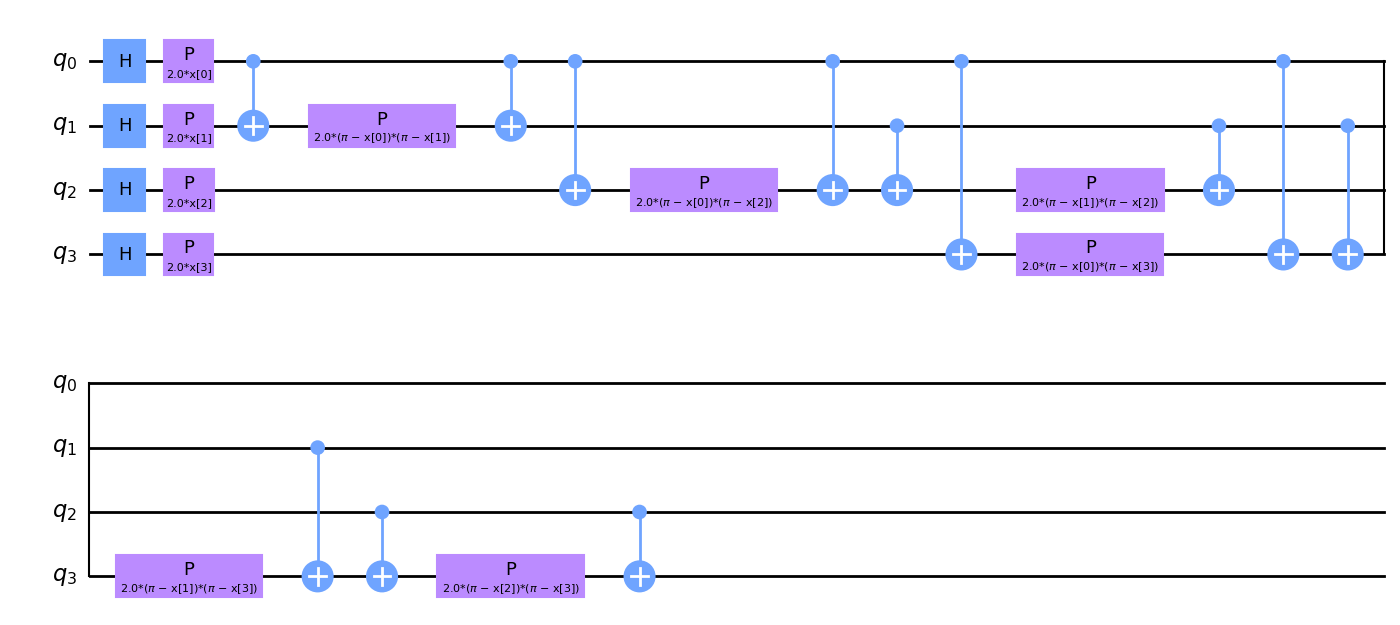

In [4]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

##### Ansatz Preperation

/Users/soap/miniconda3/envs/qc/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


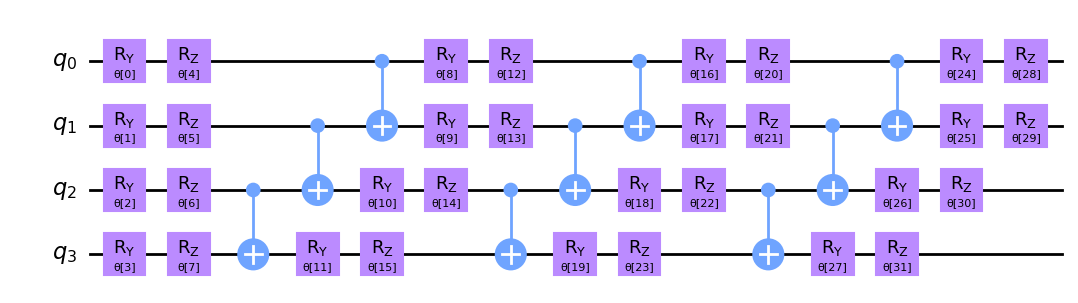

In [5]:
ansatz = EfficientSU2(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [6]:
optimizer = COBYLA(maxiter=100) # gradient free optimizer

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

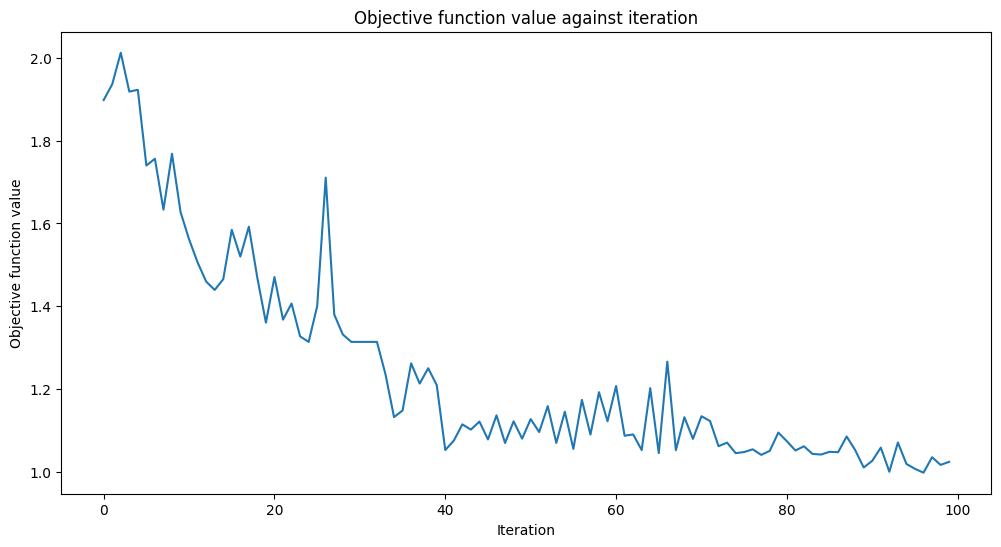

Training time: 38 seconds


In [7]:
vqc = VQC(
    sampler=Sampler(),
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.83
Quantum VQC on the test dataset:     0.80


In [21]:
# fake backends v2

fake_devices_instances = [
    fb.FakeAlmadenV2(),
    # fb.FakeArmonkV2(), one qubit backend
    fb.FakeAthensV2(),
    fb.FakeAuckland(),
    fb.FakeBelemV2(),
    fb.FakeBoeblingenV2(),
    fb.FakeBogotaV2(),
    fb.FakeBrooklynV2(),
    fb.FakeBurlingtonV2(),
    fb.FakeCairoV2(),
    fb.FakeCambridgeV2(),
    fb.FakeCasablancaV2(),
    fb.FakeEssexV2(),
    fb.FakeGeneva(),
    fb.FakeGuadalupeV2(),
    fb.FakeHanoiV2(),
    fb.FakeJakartaV2(),
    fb.FakeJohannesburgV2(),
    fb.FakeKolkataV2(),
    fb.FakeLagosV2(),
    fb.FakeLimaV2(),
    fb.FakeLondonV2(),
    fb.FakeManhattanV2(),
    fb.FakeManilaV2(),
    fb.FakeMelbourneV2(),
    fb.FakeMontrealV2(),
    fb.FakeMumbaiV2(),
    fb.FakeNairobiV2(),
    fb.FakeOslo(),
    fb.FakeOurenseV2(),
    fb.FakeParisV2(),
    fb.FakePerth(),
    fb.FakePrague(),
    fb.FakePoughkeepsieV2(),
    fb.FakeQuitoV2(),
    fb.FakeRochesterV2(),
    fb.FakeRomeV2(),
    fb.FakeSantiagoV2(),
    fb.FakeSherbrooke(),
    fb.FakeSingaporeV2(),
    fb.FakeSydneyV2(),
    fb.FakeTorontoV2(),
    fb.FakeValenciaV2(),
    fb.FakeVigoV2(),
    fb.FakeWashingtonV2(),
    fb.FakeYorktownV2()
]

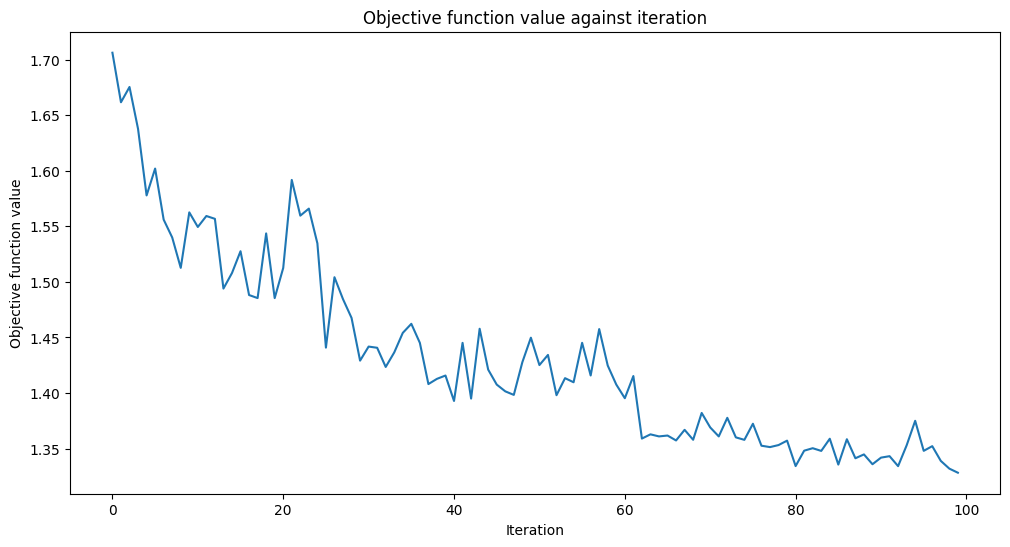

In [22]:
scores = []
for fake_device in fake_devices_instances:
    vqc = VQC(
        sampler=BackendSampler(backend=fake_device),
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph
    )

    objective_func_vals = []
    vqc.fit(train_features, train_labels)

    tr_score = vqc.score(train_features, train_labels)
    te_score = vqc.score(test_features, test_labels)

    scores.append((fake_device, (tr_score, te_score)))

In [69]:
readout_errors = []
test_scores = []

for score in scores:
    readout_error_prob = []
    for err in NoiseModel.from_backend(score[0]).to_dict()['errors']:
        if err['type'] == 'roerror':
            readout_error_prob.append(err['probabilities'][0][1])

    readout_errors.append(sum(readout_error_prob)/len(readout_error_prob))
    test_scores.append(score[1][1])

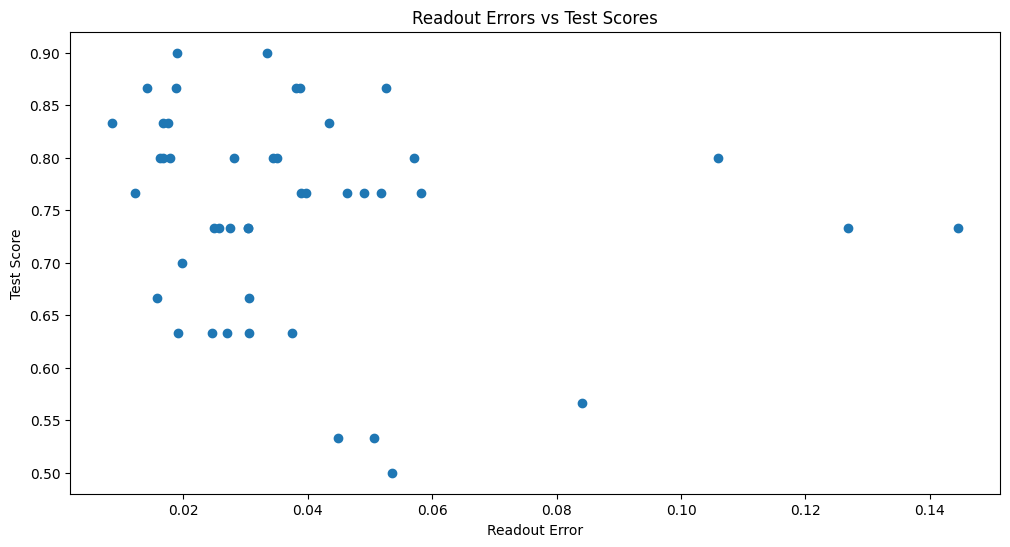

In [70]:
plt.rcParams["figure.figsize"] = (12, 6)

plt.title("Readout Errors vs Test Scores")
plt.xlabel("Readout Error")
plt.ylabel("Test Score")
plt.plot(readout_errors, test_scores, 'o')
plt.show()

In [6]:
for err in NoiseModel.from_backend(fb.FakeYorktownV2()).to_dict()['errors']:
    if err['type'] == 'roerror':
        print(err)

{'type': 'roerror', 'operations': ['measure'], 'probabilities': [[0.9367, 0.06330000000000002], [0.06330000000000002, 0.9367]], 'gate_qubits': [(0,)]}
{'type': 'roerror', 'operations': ['measure'], 'probabilities': [[0.9689, 0.031100000000000017], [0.031100000000000017, 0.9689]], 'gate_qubits': [(1,)]}
{'type': 'roerror', 'operations': ['measure'], 'probabilities': [[0.8848, 0.11519999999999997], [0.11519999999999997, 0.8848]], 'gate_qubits': [(2,)]}
{'type': 'roerror', 'operations': ['measure'], 'probabilities': [[0.9722999999999999, 0.027700000000000058], [0.027700000000000058, 0.9722999999999999]], 'gate_qubits': [(3,)]}
{'type': 'roerror', 'operations': ['measure'], 'probabilities': [[0.7077, 0.2923], [0.2923, 0.7077]], 'gate_qubits': [(4,)]}
